In [1]:
import os
import numpy as np
import pandas as pd
import re
import fnmatch
import matplotlib
import xlrd

In [2]:
# load raw dataset, comes as xlxs
main_path = '/Users/Example'
xls_filepath = os.path.join(main_path, 'dataset.xlsx')
all_data = pd.read_excel(xls_filepath)

In [3]:
# load processed, pre-selected SARS-CoV2 outcomes
# set index to patient IDs
main_path = '/Users/Example/'
outcomes_filepath = os.path.join(main_path, 'outcomes_bloodwork_subset.csv')
outcomes_pd = pd.read_csv(outcomes_filepath, index_col= 'Patient.ID')

In [4]:
# load processed, pre-selected features to choose from
# set index to patient IDs
main_path = '/Users/Example/'
features_filepath = os.path.join(main_path, 'COVID_rawdata_bloodwork_subset.csv')
all_features_pd = pd.read_csv(features_filepath, index_col= 'Patient.ID')

In [5]:
#obtained de-identified patient IDs
patient_list = all_features_pd.index.tolist()

# Decide on which features to use for predicting COVID19 status

In [6]:
# available features to choose from
print(all_features_pd.columns)

Index(['Unnamed: 0', 'Hematocrit', 'Hemoglobin', 'Platelets',
       'Red.blood.Cells', 'Lymphocytes',
       'Mean.corpuscular.hemoglobin.concentration..MCHC.', 'Leukocytes',
       'Basophils', 'Mean.corpuscular.hemoglobin..MCH.', 'Eosinophils',
       'Mean.corpuscular.volume..MCV.',
       'Red.blood.cell.distribution.width..RDW.', 'Monocytes',
       'Mean.platelet.volume', 'Neutrophils', 'Proteina.C.reativa.mg.dL'],
      dtype='object')


In [7]:
# select features that will be used downstrem and imputed
use_feature_list = ['Hematocrit', 'Hemoglobin', 'Platelets', 'Red.blood.Cells',
       'Lymphocytes', 'Mean.corpuscular.hemoglobin.concentration..MCHC.',
       'Leukocytes', 'Basophils', 'Mean.corpuscular.hemoglobin..MCH.',
       'Eosinophils', 'Mean.corpuscular.volume..MCV.',
       'Red.blood.cell.distribution.width..RDW.', 'Monocytes',
       'Mean.platelet.volume', 'Neutrophils', 'Proteina.C.reativa.mg.dL']

# Impute missing data

In [8]:
from sklearn.experimental import enable_iterative_imputer # explicitly require this experimental feature
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge #import regressor used for imputation, in this case BayesianRidge

In [9]:
# set up figure parameters
plt.rcParams['figure.dpi'] = 180
sns.set_context('talk', font_scale= 1.2)

In [10]:
# define imputer
imputer = IterativeImputer(estimator= BayesianRidge(), missing_values=np.nan, random_state=1, add_indicator=False, n_nearest_features=None, sample_posterior=True)

In [11]:
# get numpy values from features in dataframe
X = all_features_pd.loc[:, use_feature_list].values

In [12]:
completed_vals = imputer.fit_transform(X)

In [13]:
# place dataset with completed values into pandas dataframe
completed_vals_pd = pd.DataFrame(data = completed_vals, index = patient_list, columns = use_feature_list)

In [14]:
# concatenate outcomes and features with imputation
updated_full_pd = pd.concat([outcomes_pd, completed_vals_pd], axis=1)

In [15]:
# standardize previously imputed features that will be used downstream to predict COVID19 status
updated_full_pd[use_feature_list] = updated_full_pd[use_feature_list].apply(lambda x:(x-x.mean()) / (x.max()-x.min()))

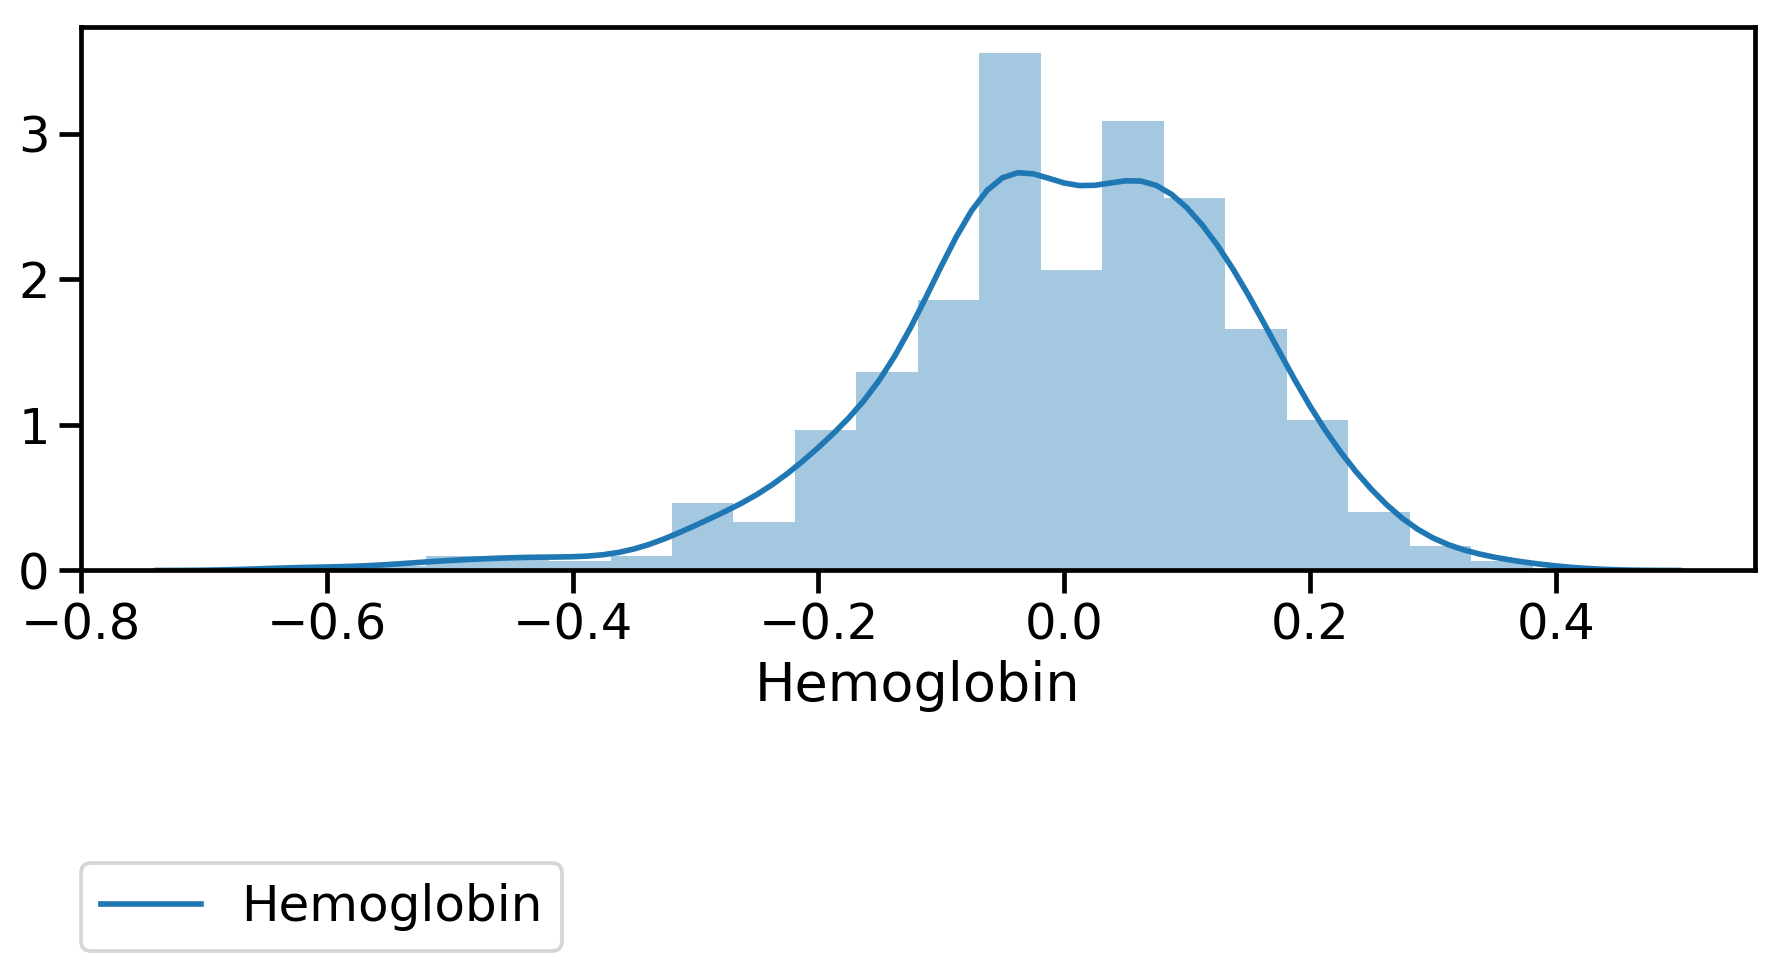

In [16]:
# check that standardization was successful
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(updated_full_pd['Hemoglobin'],  bins=20, kde_kws={'label': 'Hemoglobin'}, ax = ax)
plt.legend(loc=(0, -0.7), prop=dict(size=20))
plt.show()

In [17]:
# save as csv file
main_path = '/Users/Example/'
imp_filepath = os.path.join(main_path, 'COVID_imp.csv')
updated_full_pd.to_csv(imp_filepath, index = False)

# Generate training and test sets for classifier

In [18]:
# separate negative from positive cases
cov19pos = updated_full_pd[updated_full_pd['SARS.Cov.2.exam.result'] == 'positive']
cov19neg = updated_full_pd[updated_full_pd['SARS.Cov.2.exam.result'] == 'negative']
# going to use 45 covid19 positive cases and 135 negative cases (25% positive) in training set
# randomly sample for each set
train_pos = cov19pos.sample(n = 45, random_state = 1, axis = 0)
test_pos = cov19pos.drop(train_pos.index)
train_neg = cov19neg.sample(n = 135, random_state = 1, axis = 0)
test_neg = cov19neg.drop(train_neg.index)
# concatenate negative and positive samples for a full training and test set
train_full = pd.concat([train_pos, train_neg], axis=0)
test_full = pd.concat([test_pos, test_neg], axis=0)

In [19]:
# numerically encode "negative" and "positive" classes, will be usefull downstream for classifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [20]:
# define encoder
label_encoder = LabelEncoder()
# encode training and sets
train_full.loc[:,'SARS.Cov.2.exam.result'] = label_encoder.fit_transform(train_full.loc[:,'SARS.Cov.2.exam.result']).astype('float64')
test_full.loc[:,'SARS.Cov.2.exam.result'] = label_encoder.fit_transform(test_full.loc[:,'SARS.Cov.2.exam.result']).astype('float64')

In [21]:
# define features to use for prediction
features = ['Hematocrit', 'Hemoglobin', 'Platelets', 'Red.blood.Cells',
       'Lymphocytes', 'Mean.corpuscular.hemoglobin.concentration..MCHC.',
       'Leukocytes', 'Basophils', 'Mean.corpuscular.hemoglobin..MCH.',
       'Eosinophils', 'Mean.corpuscular.volume..MCV.',
       'Red.blood.cell.distribution.width..RDW.', 'Monocytes',
       'Mean.platelet.volume', 'Neutrophils', 'Proteina.C.reativa.mg.dL']
# target prediction is COVID19 status
target = 'SARS.Cov.2.exam.result'

In [22]:
# get numpy values
X_train = train_full.loc[:, features].values
Y_train = train_full.loc[:, target].values
X_test = test_full.loc[:, features].values
Y_test = test_full.loc[:, target].values

# separate positive and negative examples for trainig and test set as numpy arrays
X_train_pos = train_pos.loc[:, features].values
X_test_pos = test_pos.loc[:, features].values
X_train_neg = train_neg.loc[:, features].values 
X_test_neg = test_neg.loc[:, features].values

# Set up for logistic regression

In [23]:
from sklearn.linear_model import LogisticRegressionCV

In [24]:
# optimize logistic regression model 
Cs = [1, 5, 10, 20, 40, 80, 160, 320]
logfit = LogisticRegressionCV(Cs, cv = 10)
# train optimized classifier
logfit.fit(X_train,Y_train)
# optimal hyperparameter C
print(logfit.C_)

/Users/bendalllab/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass Cs=[1, 5, 10, 20, 40, 80, 160, 320] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[160]


# Determine probability distribution for each class to define classification threshold

In [25]:
#get predicted probabilities for class "1" = "positve" for COVID19
train_pos_pob = logfit.predict_proba(X_train_pos)[:, 1]
train_neg_pob = logfit.predict_proba(X_train_neg)[:, 1]
test_pos_pob = logfit.predict_proba(X_test_pos)[:, 1]
test_neg_pob = logfit.predict_proba(X_test_neg)[:, 1]

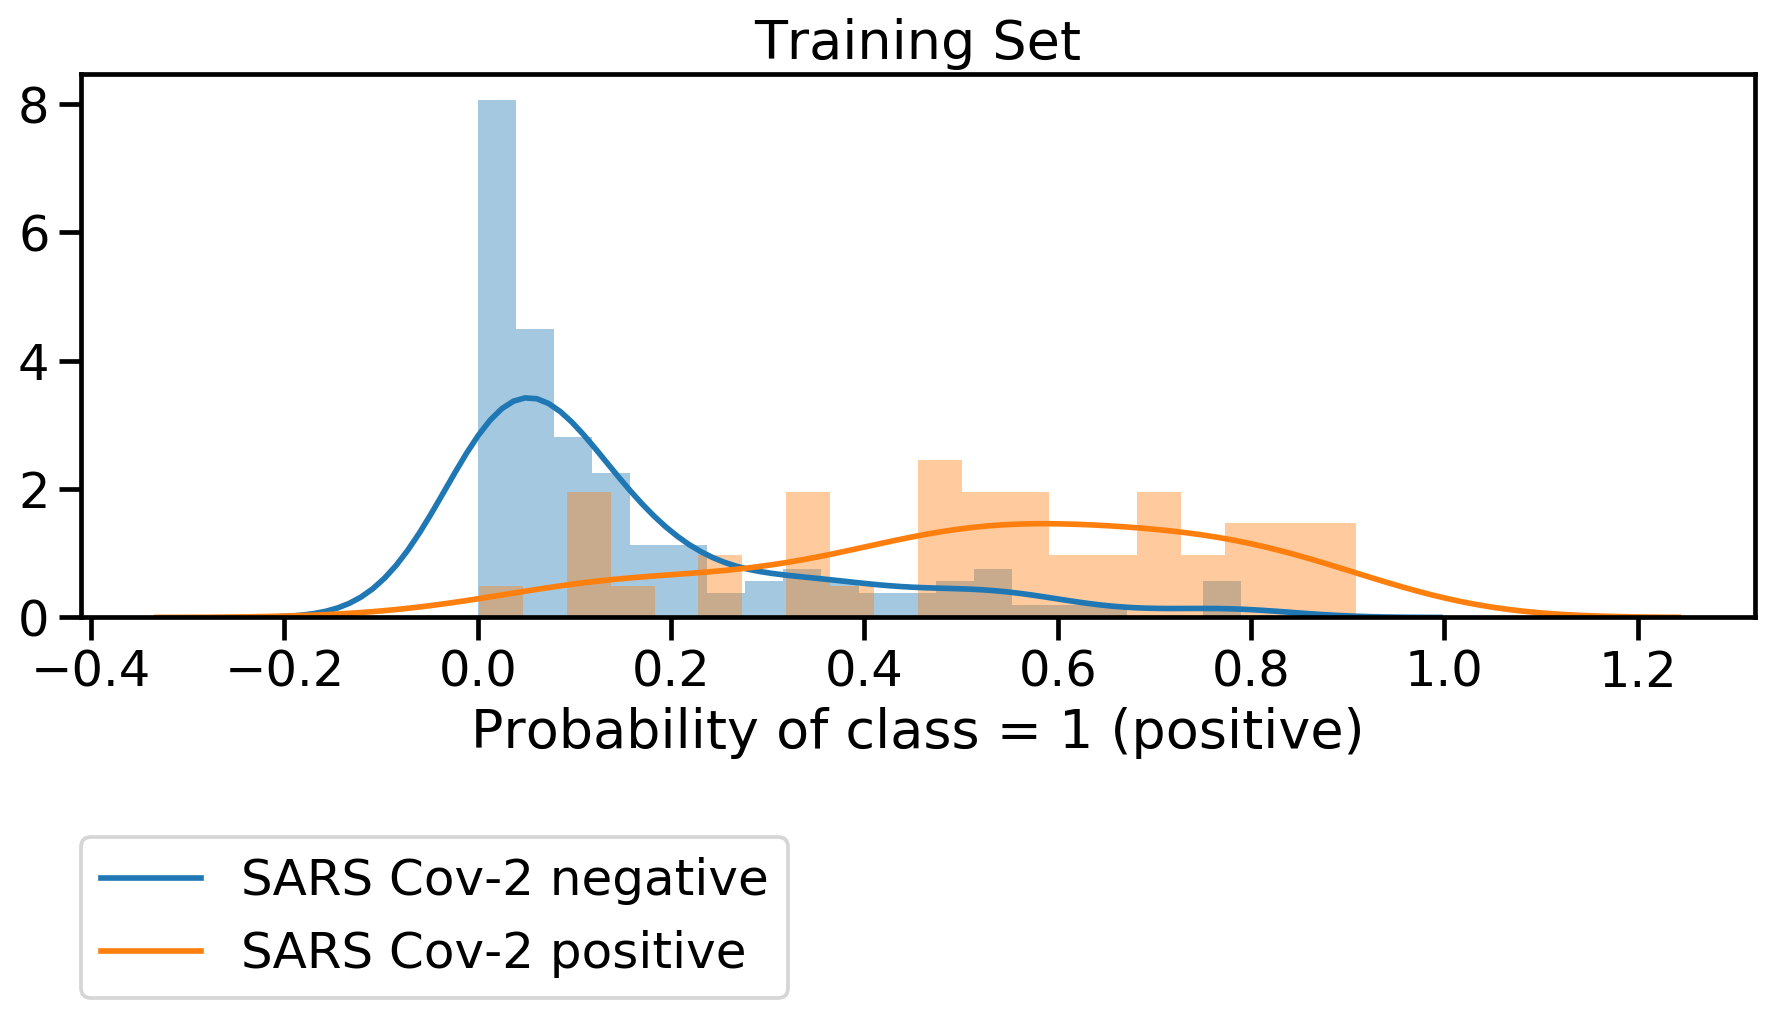

In [26]:
# plot training porbability distributions
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(train_neg_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 negative'}, ax = ax)
sns.distplot(train_pos_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 positive'}, ax = ax)
plt.title('Training Set')
plt.xlabel('Probability of class = 1 (positive)')
plt.legend(loc=(0, -0.7), prop=dict(size=20))

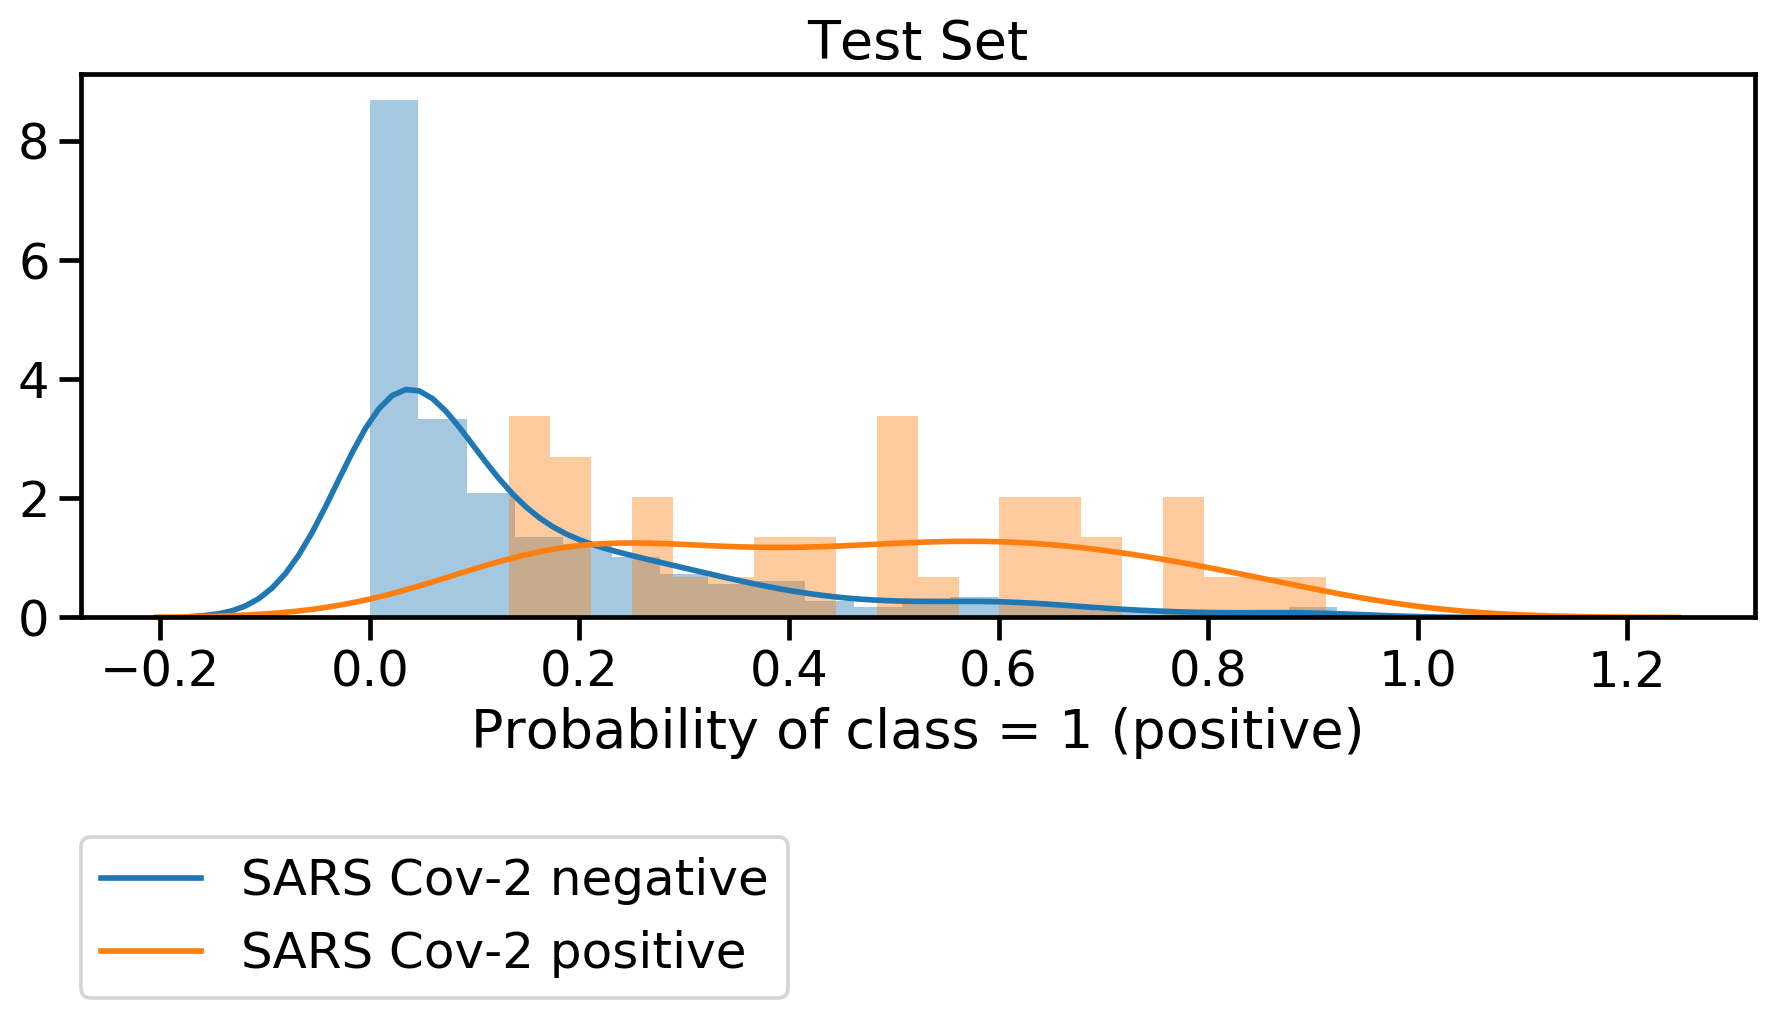

In [27]:
# plot test porbability distributions
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(test_neg_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 negative'}, ax = ax)
sns.distplot(test_pos_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 positive'}, ax = ax)
plt.title('Test Set')
plt.xlabel('Probability of class = 1 (positive)')
plt.legend(loc=(0, -0.7), prop=dict(size=20))

Set threshold to 0.275 (as opposed to the default 0.5)

# Perfomance metrics

In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve

In [29]:
# determine probabilities of assignment class 1 (= covid19 positive) for training and test sets 
train_proba_of1 = logfit.predict_proba(X_train)[:, 1]
test_proba_of1 = logfit.predict_proba(X_test)[:, 1]

In [30]:
# predict each class with threshold set to 0.275
# < 0.275 = 0 (negative)
# >= 0.275 = 1 (positive)
predict_class_train = np.where(train_proba_of1 < 0.275, 0, 1)
predict_class_test = np.where(test_proba_of1 < 0.275, 0, 1)

In [31]:
# compute confusion matrix for training set
tn, fp, fn, tp = confusion_matrix(Y_train, predict_class_train).ravel()
print('Traning set', '\n', 'TN = ', tn,'\n', 'FP = ', fp, '\n', 'FN = ', fn, '\n', 'TP = ', tp)

Traning set 
 TN =  107 
 FP =  28 
 FN =  8 
 TP =  37


In [32]:
# compute confusion matrix for test set
tn, fp, fn, tp = confusion_matrix(Y_test, predict_class_test).ravel()
print('Test set', '\n', 'TN = ', tn,'\n', 'FP = ', fp, '\n', 'FN = ', fn, '\n', 'TP = ', tp)

Test set 
 TN =  313 
 FP =  71 
 FN =  10 
 TP =  28


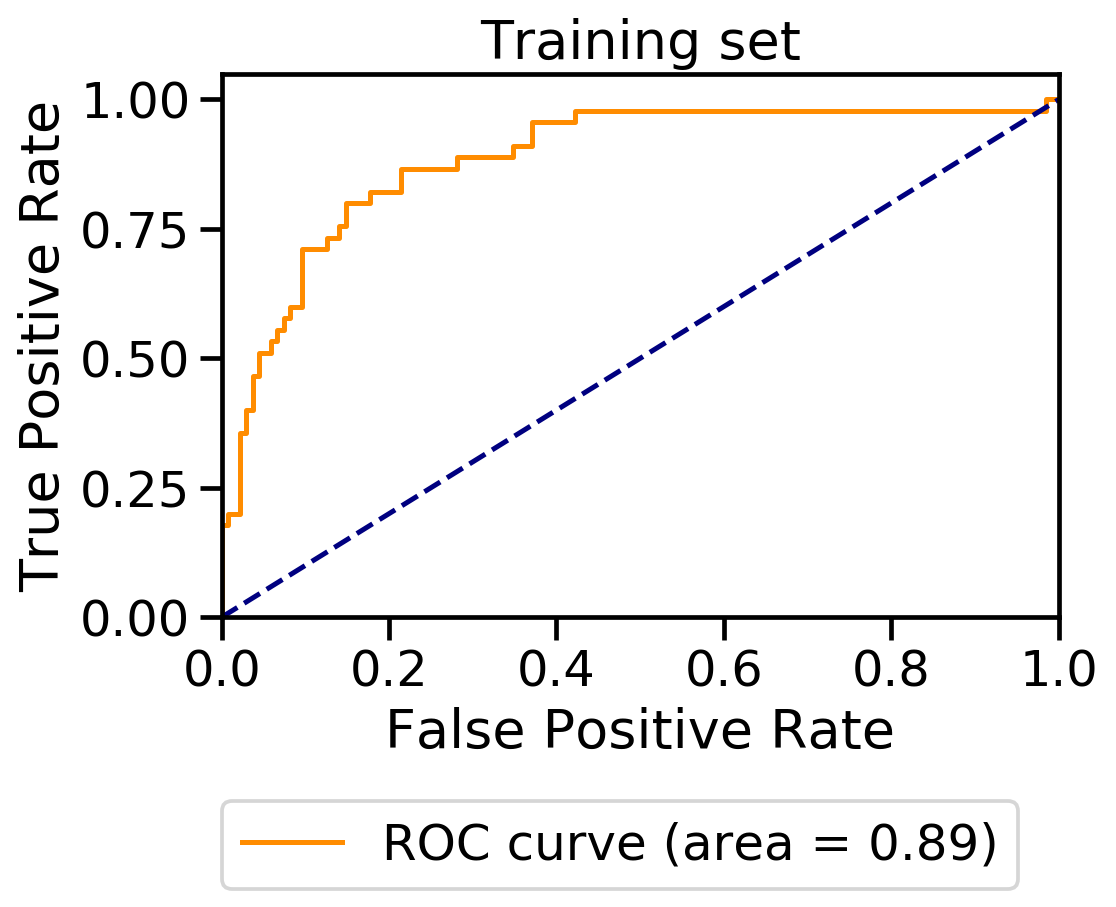

In [33]:
# Training ROC and auc
fpr, tpr, thresholds = roc_curve(Y_train, train_proba_of1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Training set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

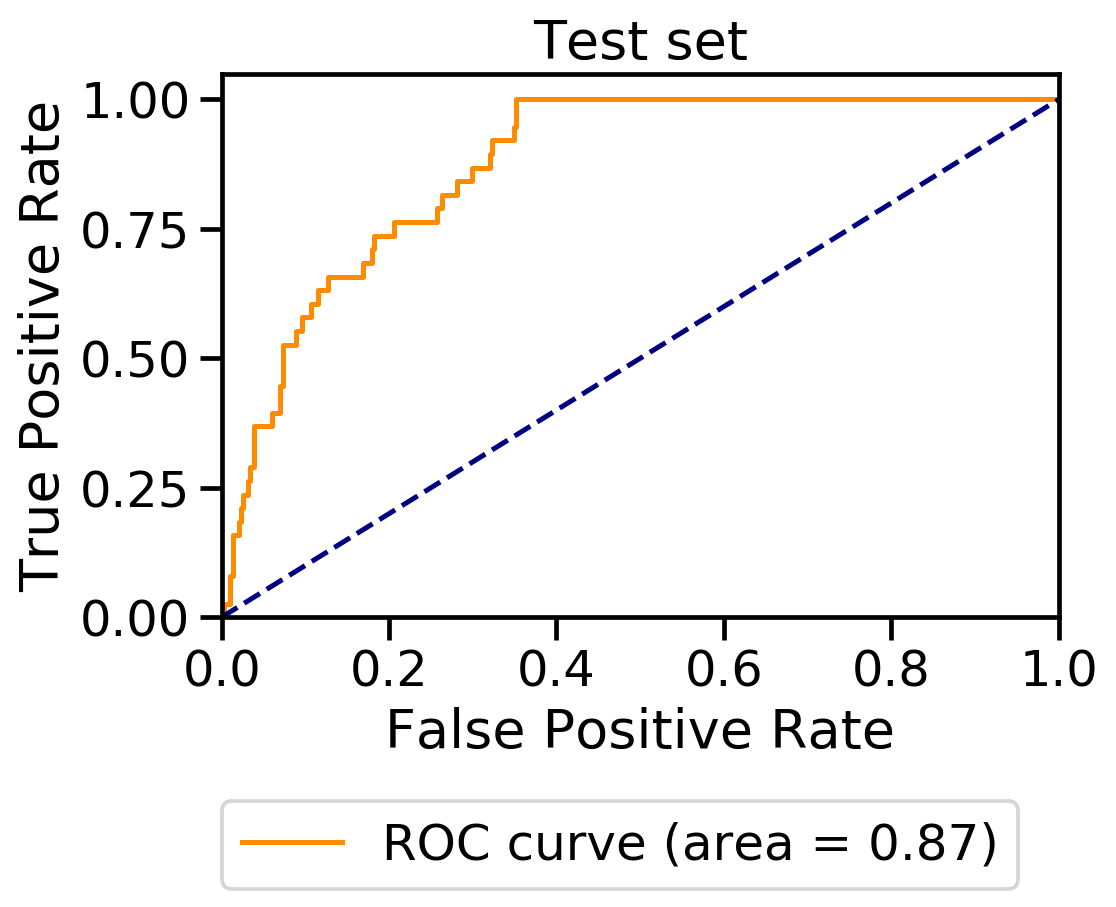

In [34]:
# Test ROC and auc
fpr, tpr, thresholds = roc_curve(Y_test, test_proba_of1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

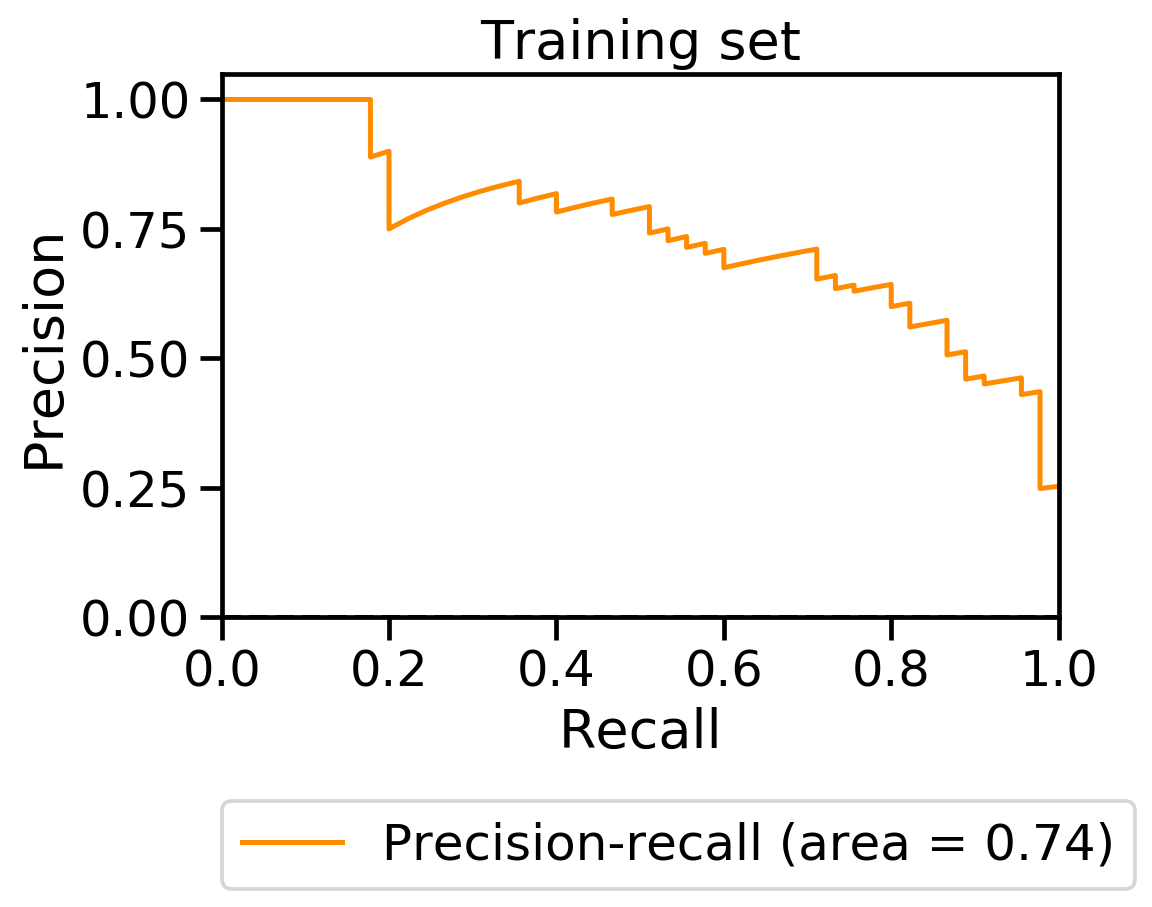

In [35]:
# Precision-recall curve for training set
precision, recall, _ = precision_recall_curve(Y_train, train_proba_of1)
average_precision = average_precision_score(Y_train, train_proba_of1)
plt.plot(recall, precision, color='darkorange', lw=2, label = 'Precision-recall (area = {0:0.2f})'.format(average_precision))
plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Training set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

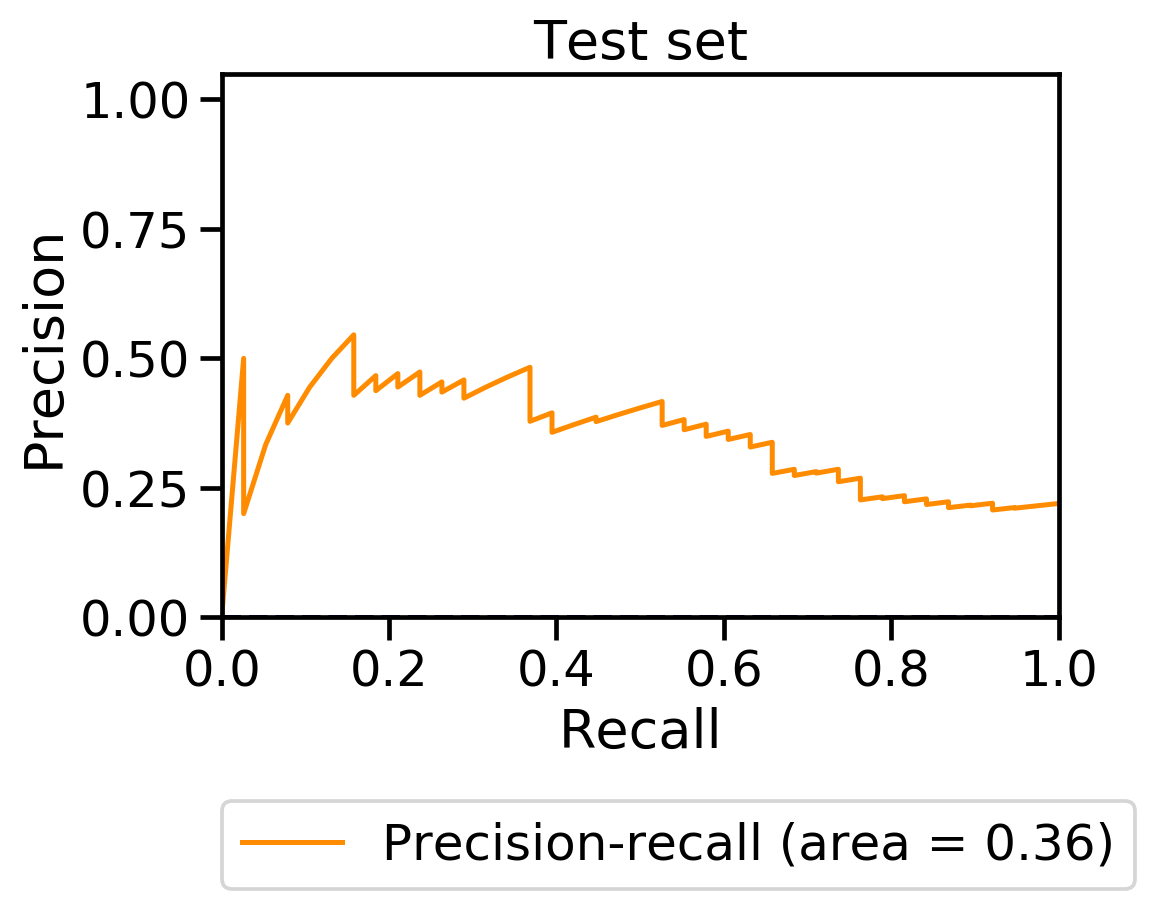

In [36]:
# Precision-recall curve for test set
precision, recall, _ = precision_recall_curve(Y_test, test_proba_of1)
average_precision = average_precision_score(Y_test, test_proba_of1)
plt.plot(recall, precision, color='darkorange', lw=2, label = 'Precision-recall (area = {0:0.2f})'.format(average_precision))
plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Test set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

# Learning curves for logistc regression

In [37]:
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [38]:
# generate optimized logistic regression model with optimal C calculated by LogisticRegressionCV
newLogFit = LogisticRegression(C = 160, random_state = 1)

In [39]:
# get values to generate learning curves, since using cv = 10, 10 curves for each train and test scores
train_sizes, train_scores, test_scores = learning_curve(newLogFit, X_train, Y_train, 
                                                        train_sizes=np.linspace(0.1, 1, 10), 
                                                        scoring = 'neg_log_loss',
                                                        cv = 10, random_state=1, shuffle=True)

In [40]:
# get means to plot just one curve for train and one curve for test
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

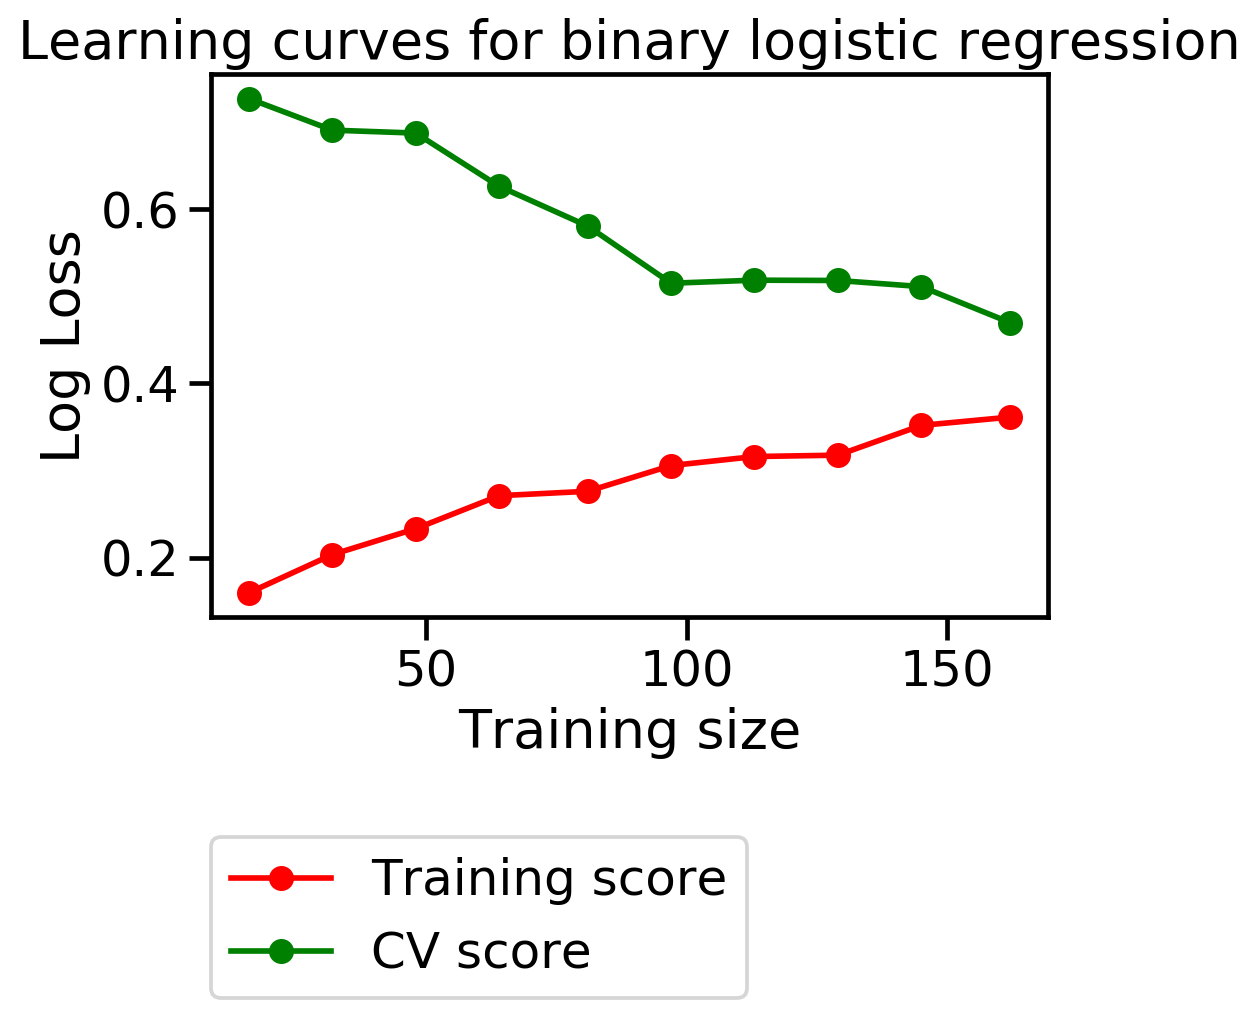

In [41]:
plt.plot(train_sizes, -train_scores_mean, 'o-', color='r',
                 label= 'Training score')
plt.plot(train_sizes, -test_scores_mean, 'o-', color='g',
                 label='CV score')
plt.xlabel('Training size')
plt.ylabel('Log Loss')
plt.title('Learning curves for binary logistic regression')
plt.legend(loc=(0, -0.7), prop=dict(size=20))
plt.show()

# Set up for neural network

In [42]:
from sklearn.neural_network import MLPClassifier # neural network classifier
from sklearn.model_selection import GridSearchCV # to find optimal hyperparameters for classifier

In [43]:
# define classifier
mlp = MLPClassifier(random_state = 1, learning_rate_init = 0.01, max_iter = 2000)

In [44]:
# hyperparameters to test out
params = {'alpha' : [1, 2, 4, 8, 10],
         'hidden_layer_sizes': [(5), (5,5), (10, 10)],
         'activation': ['identity', 'logistic', 'tanh', 'relu']}

In [45]:
# set up search for optimal hyperparameters
grid_mlp = GridSearchCV(estimator = mlp,
                        param_grid = params,
                        scoring = 'neg_log_loss', 
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1,
                       return_train_score = True)

In [46]:
# train neural network
grid_mlp.fit(X_train, Y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.1s finished


GridSearchCV(cv=10,
             estimator=MLPClassifier(learning_rate_init=0.01, max_iter=2000,
                                     random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [1, 2, 4, 8, 10],
                         'hidden_layer_sizes': [5, (5, 5), (10, 10)]},
             return_train_score=True, scoring='neg_log_loss', verbose=1)

In [47]:
print(grid_mlp.best_params_) # best hyperparameters
print(grid_mlp.best_score_) # get negative log loss for classifier with best hyperparameters

{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (5, 5)}
-0.4258514666245682


In [48]:
# define optimal classifier
mlp = MLPClassifier(hidden_layer_sizes = (5, 5), random_state = 1, 
                    learning_rate_init = 0.01, max_iter = 2000, 
                    activation='tanh', alpha = 2)
# train
mlp.fit(X_train, Y_train)

MLPClassifier(activation='tanh', alpha=2, hidden_layer_sizes=(5, 5),
              learning_rate_init=0.01, max_iter=2000, random_state=1)

# Determine probability distribution for each class to define classification threshold

In [49]:
#get predicted probabilities for class "1" = "positve" for COVID19
train_pos_pob = mlp.predict_proba(X_train_pos)[:, 1]
train_neg_pob = mlp.predict_proba(X_train_neg)[:, 1]
test_pos_pob = mlp.predict_proba(X_test_pos)[:, 1]
test_neg_pob = mlp.predict_proba(X_test_neg)[:, 1]

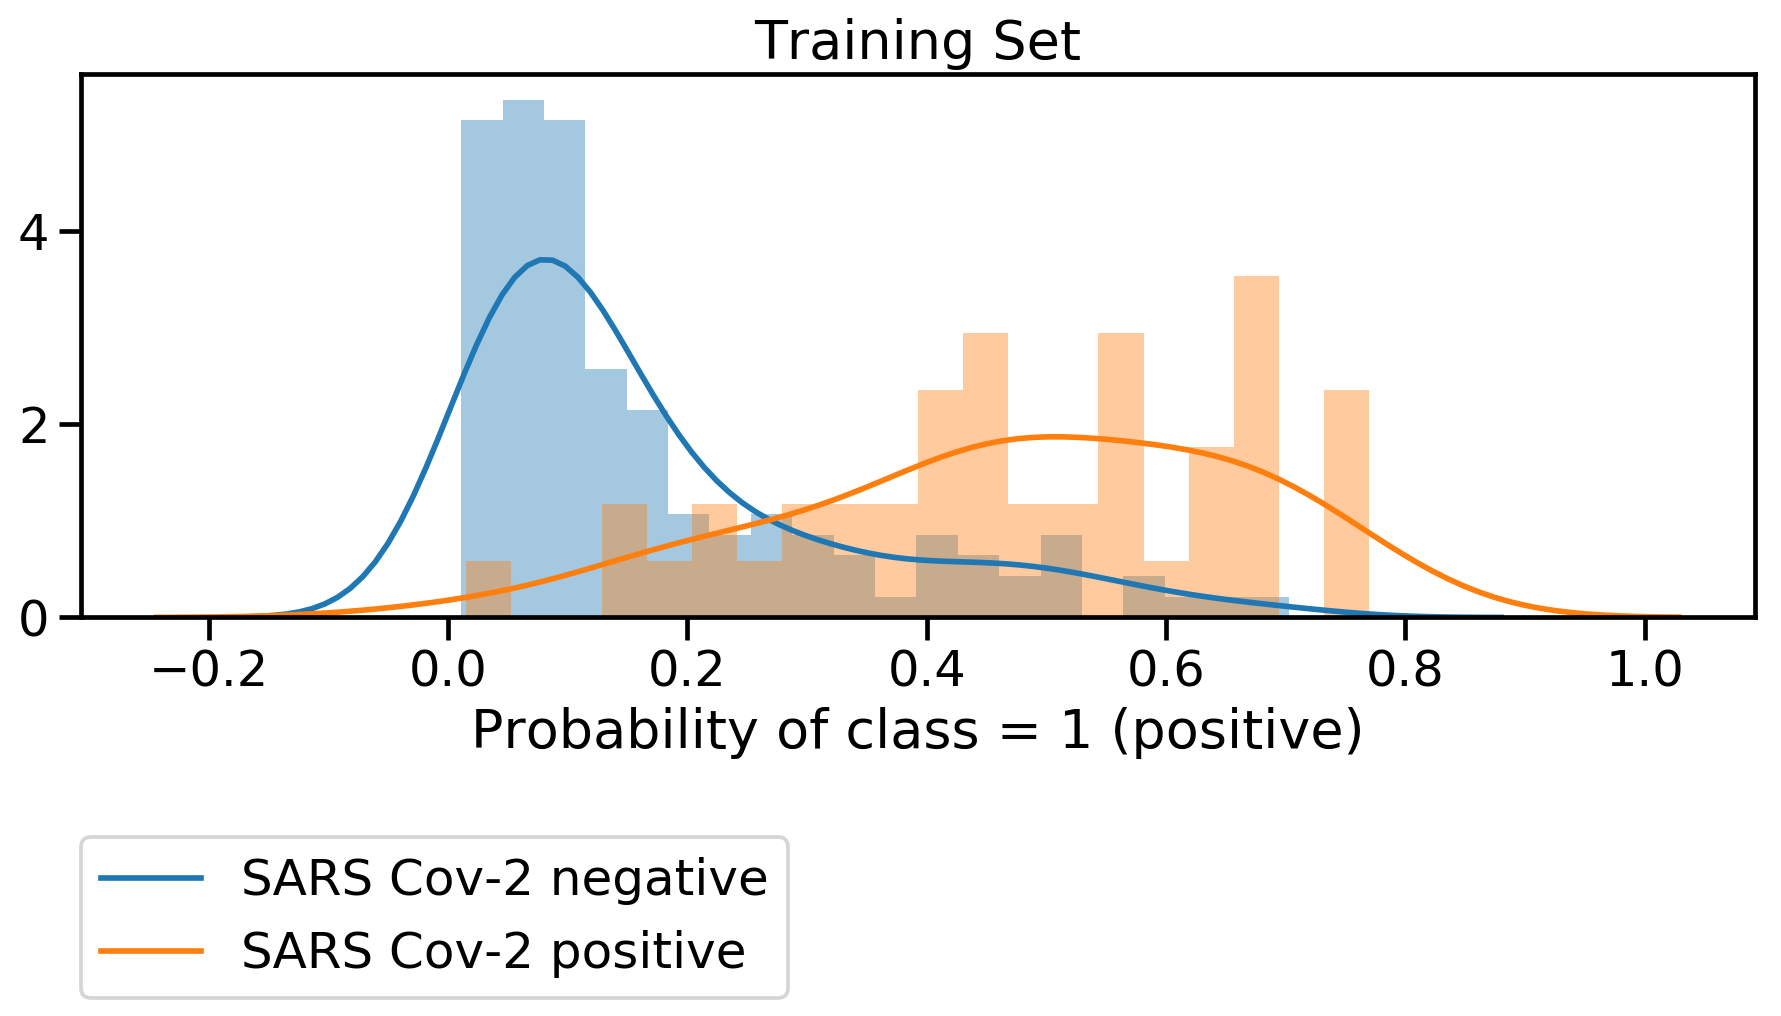

In [50]:
# plot training porbability distributions
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(train_neg_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 negative'}, ax = ax)
sns.distplot(train_pos_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 positive'}, ax = ax)
plt.title('Training Set')
plt.xlabel('Probability of class = 1 (positive)')
plt.legend(loc=(0, -0.7), prop=dict(size=20))
plt.show()

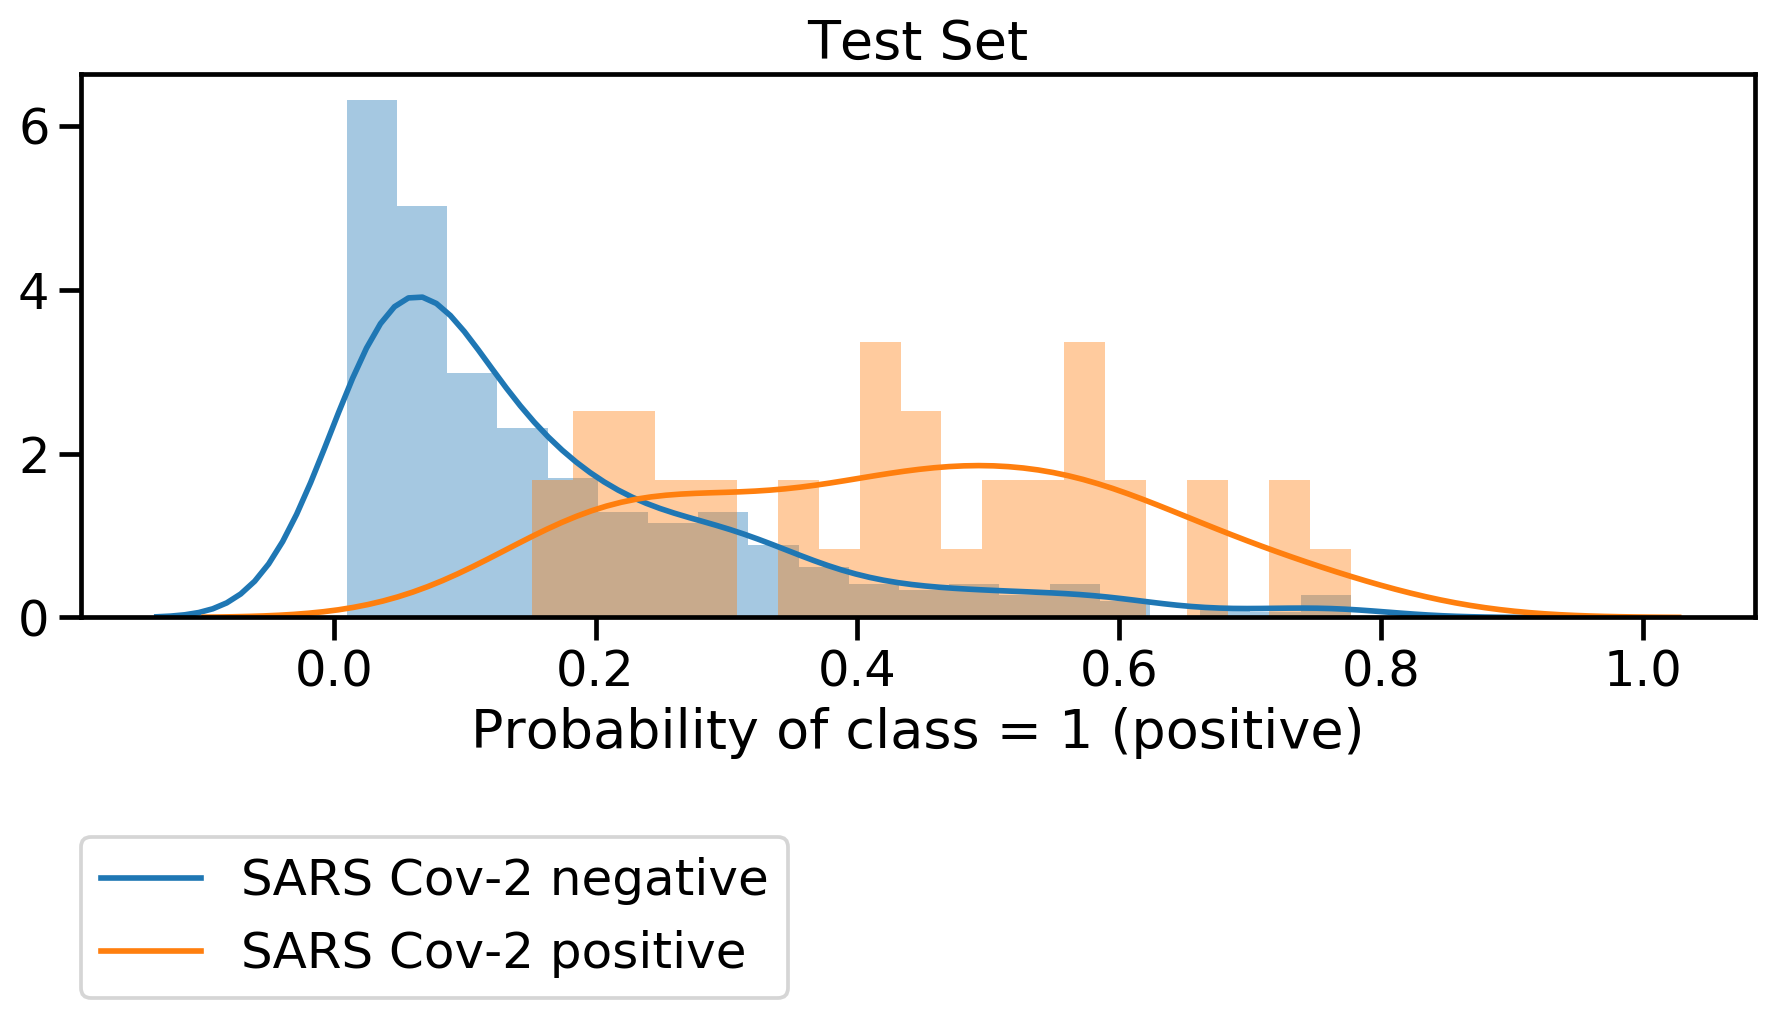

In [51]:
# plot test porbability distributions
f, ax = plt.subplots(figsize=(12, 4))
sns.distplot(test_neg_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 negative'}, ax = ax)
sns.distplot(test_pos_pob,  bins=20, kde_kws={'label': 'SARS Cov-2 positive'}, ax = ax)
plt.title('Test Set')
plt.xlabel('Probability of class = 1 (positive)')
plt.legend(loc=(0, -0.7), prop=dict(size=20))
plt.show()

Set threshold to 0.25 (as opposed to the default 0.5)

# Perfomance metrics

In [52]:
# determine probabilities of assignment class 1 (= covid19 positive) for training and test sets 
train_proba_of1 = mlp.predict_proba(X_train)[:, 1]
test_proba_of1 = mlp.predict_proba(X_test)[:, 1]

In [53]:
# predict each class with threshold set to 0.25
# < 0.25 = 0 (negative)
# >= 0.25 = 1 (positive)
predict_class_train = np.where(train_proba_of1 < 0.25, 0, 1)
predict_class_test = np.where(test_proba_of1 < 0.25, 0, 1)

In [55]:
# compute confusion matrix for training set
tn, fp, fn, tp = confusion_matrix(Y_train, predict_class_train).ravel()
print('Training', '\n', 'TN = ', tn,'\n', 'FP = ', fp, '\n', 'FN = ', fn, '\n', 'TP = ', tp)

Training 
 TN =  104 
 FP =  31 
 FN =  7 
 TP =  38


In [56]:
# compute confusion matrix for test set
tn, fp, fn, tp = confusion_matrix(Y_test, predict_class_test).ravel()
print('Test', '\n', 'TN = ', tn,'\n', 'FP = ', fp, '\n', 'FN = ', fn, '\n', 'TP = ', tp)

Test 
 TN =  295 
 FP =  89 
 FN =  8 
 TP =  30


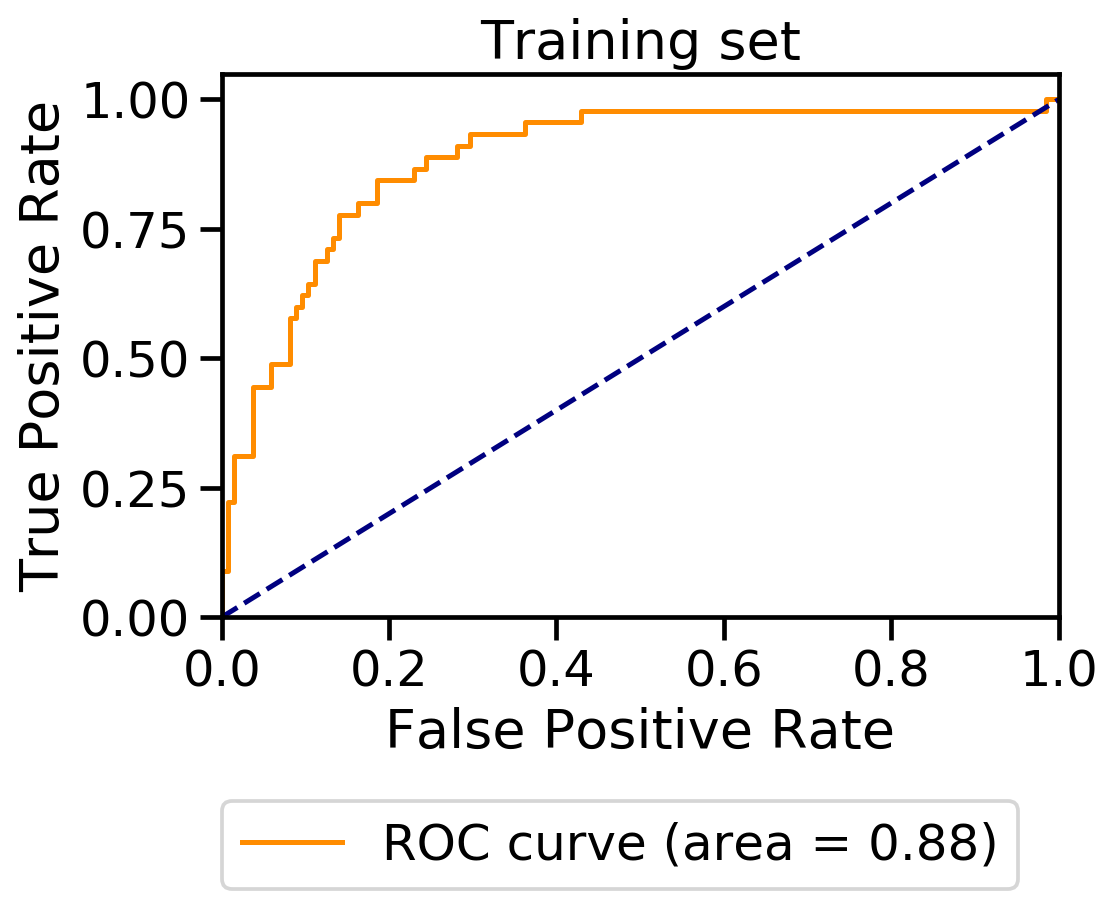

In [57]:
# Training ROC and auc
fpr, tpr, thresholds = roc_curve(Y_train, train_proba_of1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Training set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

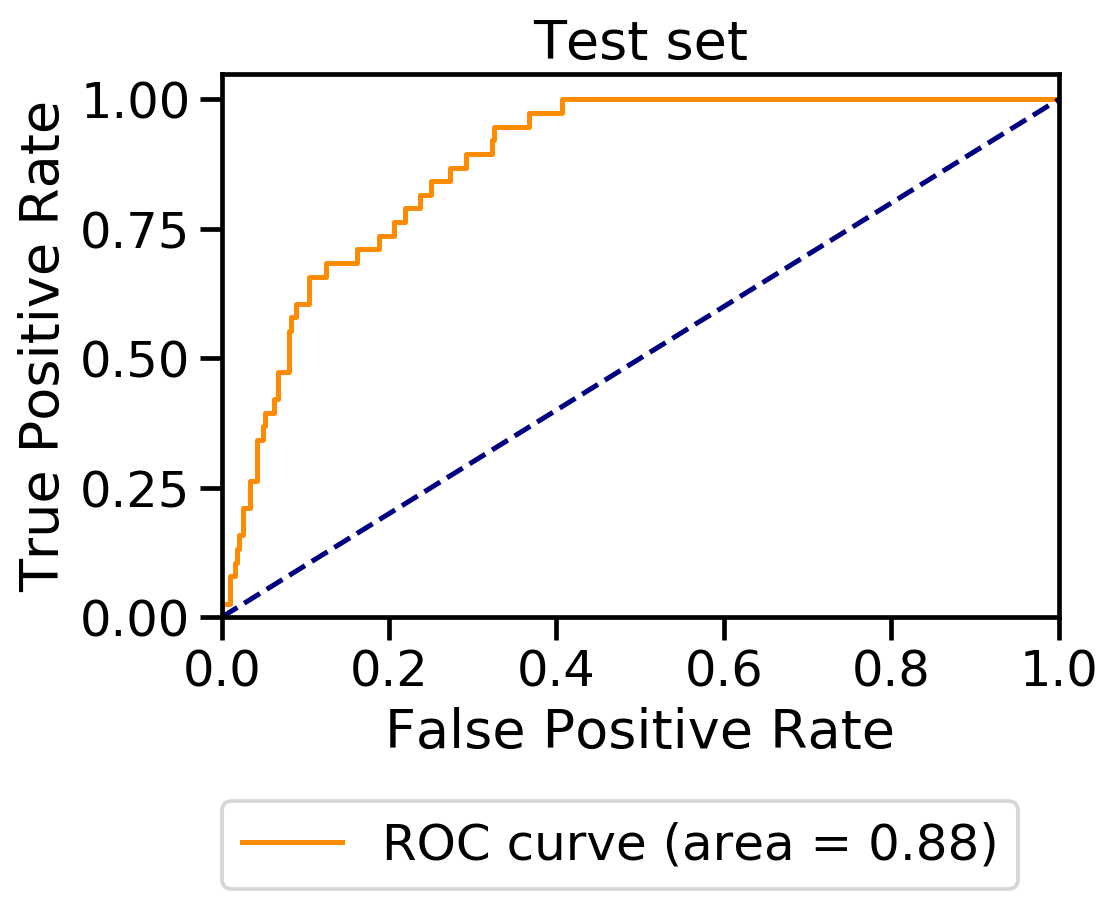

In [58]:
# Test ROC and auc
fpr, tpr, thresholds = roc_curve(Y_test, test_proba_of1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

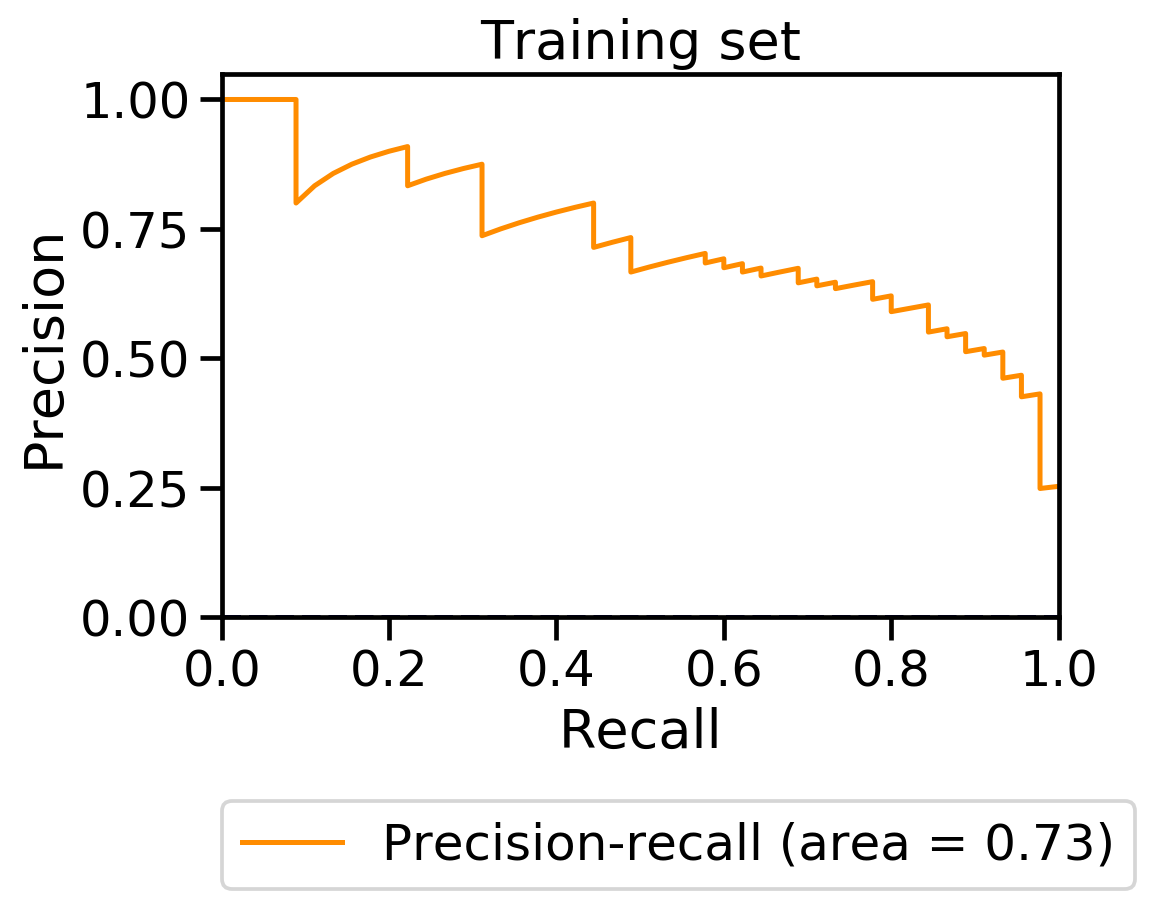

In [59]:
# Precision-recall curve for training set
precision, recall, _ = precision_recall_curve(Y_train, train_proba_of1)
average_precision = average_precision_score(Y_train, train_proba_of1)
plt.plot(recall, precision, color='darkorange', lw=2, label = 'Precision-recall (area = {0:0.2f})'.format(average_precision))
plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Training set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()

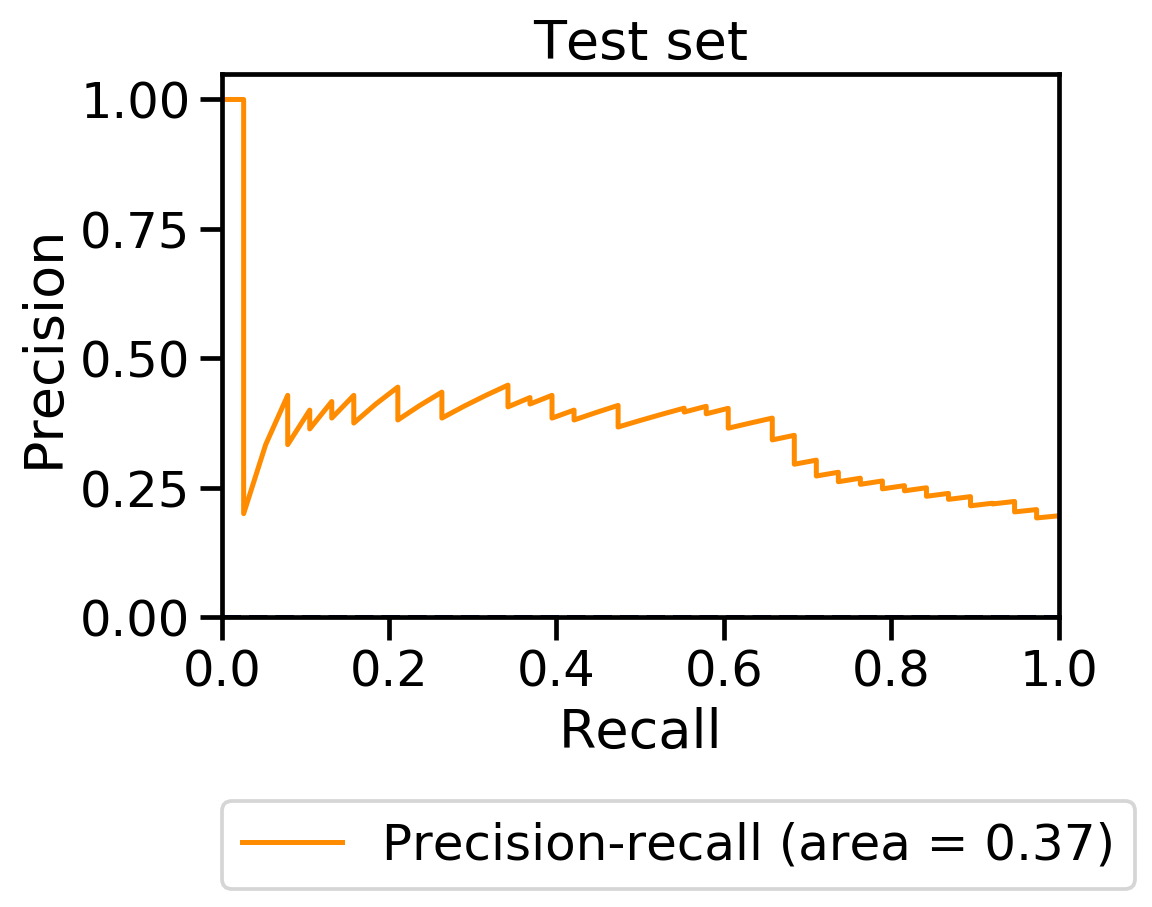

In [60]:
# Precision-recall curve for test set
precision, recall, _ = precision_recall_curve(Y_test, test_proba_of1)
average_precision = average_precision_score(Y_test, test_proba_of1)
plt.plot(recall, precision, color='darkorange', lw=2, label = 'Precision-recall (area = {0:0.2f})'.format(average_precision))
plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Test set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=(0, -0.5), prop=dict(size=20))
plt.show()